In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import dask
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
from caseva.models import ThresholdExcessModel

In [2]:
# Define input data location.
PATH_ROOT = Path().resolve().parent
PATH_DATA = PATH_ROOT / "data"

In [3]:
@dask.delayed
def calc_single_sample(extremes, threshold, num_years, m):
    sample = np.random.choice(extremes, size=extremes.size, replace=True)

    model = ThresholdExcessModel()
    model.fit(data=sample, threshold=threshold, num_years=num_years)

    probas = np.arange(1, m + 1) / (m + 1)
    quants = model.dist.quantile(model.theta, probas)

    distances = np.quantile(sample, probas) - quants

    return np.mean(np.abs(distances))


def calc_bootstrap_mean_dist(extremes, threshold, num_years, k, m):

    calculations = []

    for _ in range(k):
        calc = calc_single_sample(extremes, threshold, num_years, m)
        calculations.append(calc)
    
    return dask.delayed(np.mean)(calculations)


def get_threshold(data, num_years, k, m, min_num_extremes=15):


    thresholds = np.quantile(data, np.linspace(0.70, 0.999, 1000))
    #thresholds = np.linspace(20, 35, 50)
    mean_distances = np.zeros_like(thresholds)
    
    for i, u in enumerate(thresholds):

        extremes = data[data > u]
        if extremes.size < min_num_extremes:
            mean_distances[i] = np.inf
            continue

        try:
            mean_distances[i] = calc_bootstrap_mean_dist(extremes, u, num_years, k, m).compute()
        except:
            mean_distances[i] = np.inf

    
    min_indx = np.argmin(mean_distances)
    return mean_distances[min_indx], mean_distances
        


In [4]:
# Load data / define threshold
data = pd.read_csv(PATH_DATA / "rain.csv", parse_dates=[0])
years = {date.year for date in data["Date"]}
num_years = max(years) - min(years) + 1


In [5]:
with LocalCluster(n_workers=10, threads_per_worker=1) as cluster:
    with Client(cluster) as client:
        threshold, dists = get_threshold(data["Rainfall"].values, num_years, k=250, m=100)

CasADi - 2024-12-23 19:24:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-12-23 19:24:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-12-23 19:24:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-12-23 19:24:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-12-23 19:24:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-12-23 19:24:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-12-23 19:24:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

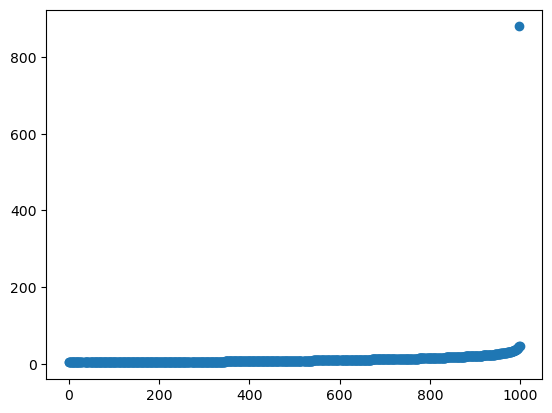

In [6]:
plt.scatter(np.arange(dists.size), dists)

In [7]:
dists

array([  3.29029005,   3.28852956,   3.28872119,   3.2913316 ,
         3.29022004,   3.29083396,   3.28977082,   3.28932974,
         3.28836866,   3.28936434,   3.28928236,   3.28957321,
         3.28990368,   3.29098418,   3.28973032,   3.29127578,
         3.29071398,   3.29025179,   3.28946844,   3.28865671,
         3.28779058,   3.28927585,   3.29037849,   3.29139332,
         3.59489775,   3.59515305,   3.59402515,   3.59718685,
                inf,   3.59453539,          inf,   3.59617652,
                inf,          inf,          inf,   3.59663076,
         3.59515245,   3.59444087,   3.59419626,   3.59554326,
         3.59493007,   3.59700231,   3.5952515 ,   3.59495534,
         3.59676498,          inf,          inf,   3.59472858,
         3.59410902,   3.59363352,   3.59507964,   3.59565472,
         3.59695676,   3.59439515,   3.59369075,   3.59372022,
         3.59586485,   3.61165635,   3.78301475,   3.78143678,
         3.78242199,   3.78175046,   3.78256661,   3.78

In [8]:
threshold

3.2877905758133847